In [1]:
import warnings
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
import lightgbm as lgb
from catboost import CatBoostRegressor

In [3]:
RANDOM_STATE = 12345

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
df_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [7]:
df_test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [8]:
pd.DataFrame(round(df_train.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
year,0.000000
make,2.000000
model,2.000000
trim,2.000000
body,2.000000
transmission,12.000000
vin,0.000000
state,0.000000
condition,2.000000
odometer,0.000000


In [9]:
pd.DataFrame(round(df_test.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
year,0.000000
make,2.000000
model,2.000000
trim,2.000000
body,2.000000
transmission,12.000000
vin,0.000000
state,0.000000
condition,2.000000
odometer,0.000000


In [10]:
t = df_train.groupby(['make','model','year'])['transmission'].value_counts(1)

def filltr(row):
    if pd.isnull(row['transmission']):
        make = row['make']
        model = row['model']
        year = row['year']
        if (make, model, year) in t.index:
            prob = t.loc[(make, model, year)]
            probtr = prob.index[0]
            return probtr
        else:
            return np.nan
    else:
        return row['transmission']
    
df_train['transmission'] = df_train.apply(filltr, axis=1)      

In [11]:
t1 = df_test.groupby(['make','model','year'])['transmission'].value_counts(1)

def fillt1(row):
    if pd.isnull(row['transmission']):
        make = row['make']
        model = row['model']
        year = row['year']
        if (make, model, year) in t1.index:
            prob = t1.loc[(make, model, year)]
            probtr = prob.index[0]
            return probtr
        else:
            return np.nan
    else:
        return row['transmission']
    
df_test['transmission'] = df_test.apply(filltr, axis=1)

In [12]:
df_train['saledate'] = df_train['saledate'].replace(to_replace ='GMT.+', value = '', regex=True)
df_test['saledate'] = df_test['saledate'].replace(to_replace ='GMT.+', value = '', regex=True)

df_train['saledate'] = df_train['saledate'].apply(pd.to_datetime)
df_test['saledate'] = df_test['saledate'].apply(pd.to_datetime)

df_train['exploit'] = (df_train['saledate'].dt.year - df_train['year'])
df_train = df_train.drop(['saledate', 'vin'], axis=1)

df_test['exploit'] = (df_test['saledate'].dt.year - df_test['year'])
df_test = df_test.drop(['saledate', 'vin'], axis=1)
#df_train.head()

Построим график машин с пробегом от 100 000 км.

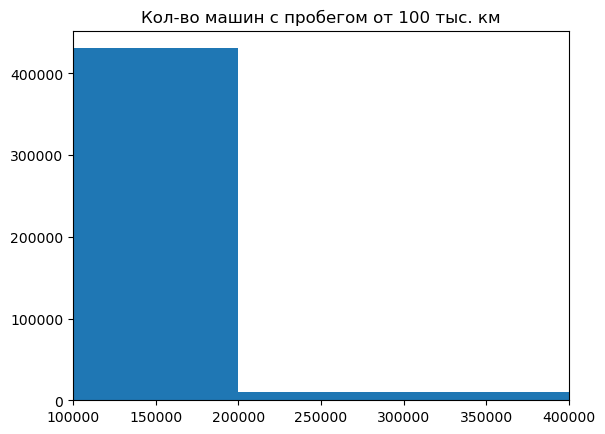

In [13]:
plt.title('Кол-во машин с пробегом от 100 тыс. км')
plt.hist(df_train['odometer'], bins=5)
plt.xlim(xmin=100000, xmax=400000)
plt.show()

По графику виден резкий обвал значений после 200 тыс. км, скорее всего это ошибка, ведь пробег в 250 тыс. уже считается большим. Поэтому уберем некорректные знаечния из нашей таблицы.

In [14]:
df_train.drop(df_train[df_train['odometer'] >= 200000].index, inplace=True)

Почистим колонку "продавец".

In [15]:
df_train['seller'] = df_train['seller'].replace(to_replace ='company.+|corporation|inc|auto\s.+|consumer.+|city.+|state.+|motor.+', 
                                                value = '', regex=True)

In [16]:
df_test['seller'] = df_test['seller'].replace(to_replace ='company.+|corporation|inc|auto\s.+|consumer.+|city.+|state.+|motor.+', 
                                                value = '', regex=True)

In [17]:
df_train.groupby('seller').filter(lambda x : len(x)==1)['seller']

35                 texas motor
127                 4jg stars 
128           allied solutions
291               storch ford 
350        franklin park loln 
                  ...         
439939                   trra 
439954      beyer brothers gmc
440053    autostar enterprises
440170         kocourek nissan
440233                 studio 
Name: seller, Length: 4042, dtype: object

Единичных продавцов много и вручную все перебирать неудобно, поэтому оставим их в таблице. 

Приведем в порядок колонку с марками автомобилей.

In [18]:
vals = {'mercedes':'Mercedes-Benz', 'bmw':'BMW', 'vw':'Volkswagen',
       'gmc truck':'GMC', 'ford truck':'Ford', 'mercedes-b':'Mercedes-Benz',
       'dodge tk':'Dodge', 'mazda tk': 'Mazda'}

df_train['make'] = df_train['make'].map(vals)
df_train['make'] = df_train['make'].str.title()
df_train['model'] = df_train['model'].str.title()

In [19]:
valst = {'mercedes':'Mercedes-Benz', 'bmw':'BMW', 'vw':'Volkswagen',
       'chev truck':'Chevrolet', 'ford tk':'Ford',
       'hundai tk':'Hundai'}

df_test['make'] = df_test['make'].map(valst)
df_test['make'] = df_test['make'].str.title()
df_test['model'] = df_test['model'].str.title()

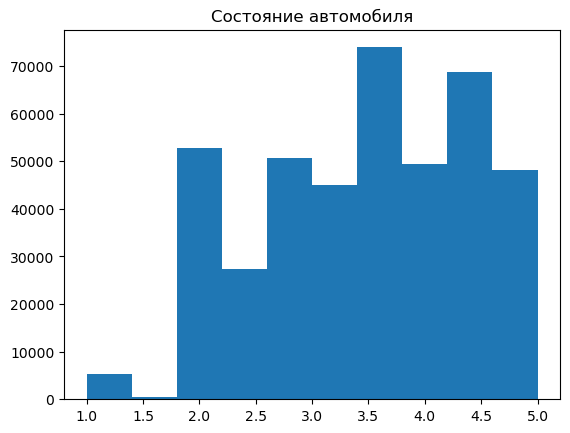

In [20]:
plt.title('Состояние автомобиля')
plt.hist(df_train['condition'])
plt.show()

Показатели оценки состояния автомобиля довольно симметричны с небольшим выбросом в единичку, поэтому заменим пропуски модой.

In [21]:
for column in df_train.columns:
    if df_train[column].dtype == 'object':
        df_train[column] = df_train[column].fillna('NA')
        df_train[column] = df_train[column].astype('category')

df_train['condition'] = df_train['condition'].fillna(df_train['condition'].mode())

In [22]:
for column in df_test.columns:
    if df_test[column].dtype == 'object':
        df_test[column] = df_test[column].fillna('NA')
        df_test[column] = df_test[column].astype('category')

df_test['condition'] = df_test['condition'].fillna(df_test['condition'].mode())

In [23]:
df_train.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,exploit
0,2011,NA,Edge,SEL,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,4
1,2014,NA,Fusion,SE,Sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,1
2,2012,NA,Sentra,2.0 SL,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,3
3,2003,NA,H2,Base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin,13300,12
4,2007,NA,Fusion,SEL,Sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,8


In [24]:
df_test.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,exploit
0,2005,NA,Cts,Base,Sedan,automatic,ca,2.7,116970.0,silver,black,lexus of stevens creek,10
1,2014,NA,Savana Cargo,2500,Van,automatic,pa,4.4,6286.0,white,gray,u-haul,1
2,2013,NA,Murano,S,SUV,automatic,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2
3,2013,NA,Impala,LS Fleet,Sedan,automatic,fl,2.3,57105.0,silver,black,onemain rem/,2
4,2013,NA,Titan,SV,Crew Cab,automatic,tn,2.9,31083.0,black,black,nissan north america .,2


## Models

In [25]:
features_train = df_train.drop('sellingprice', axis=1)
target_train = df_train['sellingprice']

In [26]:
Xe = features_train.copy()
categorical_cols= ['make','model','trim','body','transmission','state','color', 'interior','seller']
for i in categorical_cols:
    le=LabelEncoder()
    arr=np.concatenate([Xe[i]], axis=0).astype(str)
    le.fit(arr)
    Xe[i]=le.transform(Xe[i].astype(str))

In [27]:
%%time

param_lgbm = {'num_leaves' : range(10, 20), 
              'max_depth' : range(1, 10),
              'n_estimators' : range(50, 1200, 100)}

model_boost = lgb.LGBMRegressor(random_state=RANDOM_STATE)
search_boost = RandomizedSearchCV(model_boost, param_lgbm,
                        cv=5, scoring='neg_mean_absolute_percentage_error', error_score='raise')
search_boost.fit(features_train, target_train)
model_boost_final = search_boost.best_estimator_
mape_lgbm = abs(search_boost.best_score_) * 100
print('Лучшее значение MAPE:', mape_lgbm)
print('Лучшие гиперпараметры', search_boost.best_params_)

Лучшее значение MAPE: 17.731726042359316
Лучшие гиперпараметры {'num_leaves': 18, 'n_estimators': 850, 'max_depth': 8}
CPU times: total: 29min 19s
Wall time: 4min 2s


In [28]:
%%time

param_cat = {'depth' : range(6, 10),
              'iterations' : range(50, 550, 50),
            'learning_rate' : [0.1, 0.01, 1.0]}

model_cat = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)
search_cat = RandomizedSearchCV(model_cat, param_cat,
                        cv=5, scoring='neg_mean_absolute_percentage_error', error_score='raise')
search_cat.fit(Xe, target_train)
model_cat_final = search_cat.best_estimator_
mape_cat = abs(search_cat.best_score_) * 100
print('Лучшее значение MAPE:', mape_cat)
print('Лучшие гиперпараметры', search_cat.best_params_)

Лучшее значение MAPE: 26.91599926373629
Лучшие гиперпараметры {'learning_rate': 1.0, 'iterations': 400, 'depth': 8}
CPU times: total: 11min 5s
Wall time: 7min 45s


In [35]:
summary = pd.DataFrame(
    {
        'MAPE' : [mape_lgbm, mape_cat]
    },
    index = ['LGBM', 'Cat']
).sort_values(by='MAPE', ascending=True)
summary

,MAPE
LGBM,17.731726
Cat,26.915999


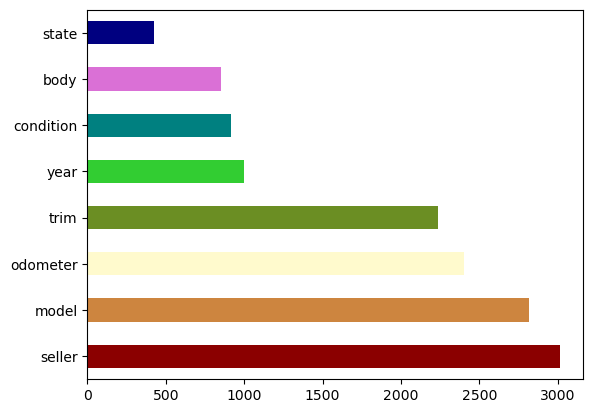

In [36]:
(pd.Series(model_boost_final.feature_importances_, index=features_train.columns)
   .nlargest(8)
   .plot(kind='barh', color=['darkred', 'peru', 'lemonchiffon', 'olivedrab',
                             'limegreen', 'teal', 'orchid', 'navy']))
plt.show()

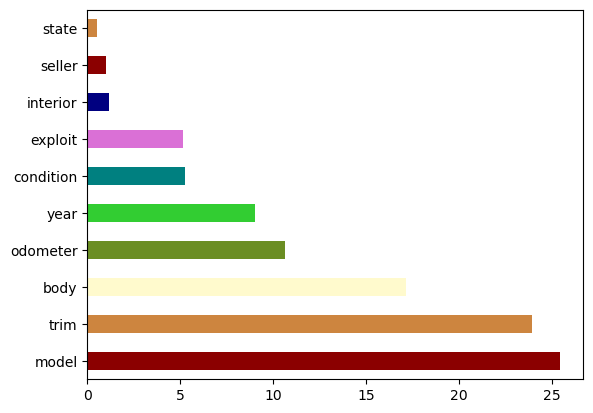

In [37]:
(pd.Series(model_cat_final.feature_importances_, index=features_train.columns)
   .nlargest(10)
   .plot(kind='barh', color=['darkred', 'peru', 'lemonchiffon', 'olivedrab',
                             'limegreen', 'teal', 'orchid', 'navy']))
plt.show()

## Testing

Лучше всех справилась LGBM, проверим нашу модель на тестовой выборке и запишем результаты в csv.

In [38]:
lgbm_predictions = model_boost_final.predict(df_test)

## Output

In [39]:
test_copy = pd.read_csv('test.csv')
output = pd.DataFrame(
    {'vin':test_copy.vin.values,'sellingprice':lgbm_predictions}
).to_csv('submission.csv', index=False)